# Recorte dos dados de chuva nos shapefiles das usinas.

In [4]:
import pandas as pd
import xarray as xr
import rioxarray as rio
import geopandas as gpd
import geojson
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sea
sea.set_style('darkgrid')

In [1]:
def cutMean(df):
    df = df.groupby('time').mean()
    BG = xr.Dataset(df)
    ends = BG.where(BG['time.month'] >= 10, drop=True)
    begins = BG.where(BG['time.month'] < 4, drop=True)
    dataset = xr.concat([ends, begins], dim='time')
    dataset = dataset.sortby(dataset.time).dropna(dim='time')
    return dataset.to_dataframe()

In [6]:
def data(shp):
    precip = xr.open_dataset("/home/data/netcdf/precip.mon.mean.nc").precip
    cut_furnas = gpd.read_file(shp)
    cut_furnas = cut_furnas.set_crs(4326)
    
    precip['lon']=np.arange(-180,180,2.5)
    
    df = precip.to_dataframe().reset_index()
    gdf = gpd.GeoDataFrame(df,geometry=gpd.points_from_xy(df['lon'],df['lat']))
    gdf = gdf.set_crs(4326)
    
    clipped = gpd.clip(gdf, cut_furnas)
    clipped = cutMean(clipped)
    clipped.to_pickle(shp[82:-4]+'.pkl')
    return clipped

In [9]:
def figura(shp):
    clipped = data(shp)
    fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(15,5))
    fig.suptitle(shp[82:-4], weight="medium",style="oblique",va="top", ha="center")
    ax.plot(clipped.index, clipped['precip'])
    ax.tick_params(axis='x', labelsize=10, rotation=45)
    plt.savefig(shp[82:-4]+'.png')

In [56]:
shp_list = ['/mnt/d/_Gabriel/Estudo/UFF/Bloqueios_Atmosfericos/shapes/shapes_smap/MODCLIM/Furnas.shp',
'/mnt/d/_Gabriel/Estudo/UFF/Bloqueios_Atmosfericos/shapes/shapes_smap/MODCLIM/Passo Real - Jacui.shp',
'/mnt/d/_Gabriel/Estudo/UFF/Bloqueios_Atmosfericos/shapes/shapes_smap/MODCLIM/Foz do Areia.shp',
'/mnt/d/_Gabriel/Estudo/UFF/Bloqueios_Atmosfericos/shapes/shapes_smap/MODCLIM/Boa Esperanca - Parnaiba.shp',
'/mnt/d/_Gabriel/Estudo/UFF/Bloqueios_Atmosfericos/shapes/shapes_smap/MODCLIM/Santo Antonio - Madeira.shp',
'/mnt/d/_Gabriel/Estudo/UFF/Bloqueios_Atmosfericos/shapes/shapes_smap/MODCLIM/Sao Simao.shp',
'/mnt/d/_Gabriel/Estudo/UFF/Bloqueios_Atmosfericos/shapes/shapes_smap/MODCLIM/Sobradinho.shp',
'/mnt/d/_Gabriel/Estudo/UFF/Bloqueios_Atmosfericos/shapes/shapes_smap/MODCLIM/Tucurui - Tocantins.shp']

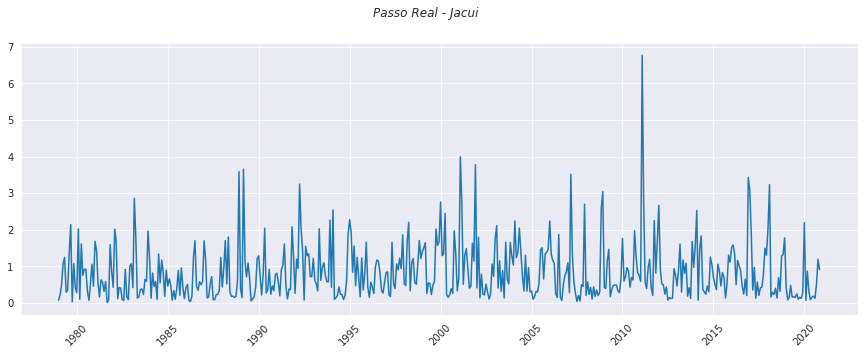

In [82]:
figura('/mnt/d/_Gabriel/Estudo/UFF/Bloqueios_Atmosfericos/shapes/shapes_smap/MODCLIM/Passo Real - Jacui.shp')

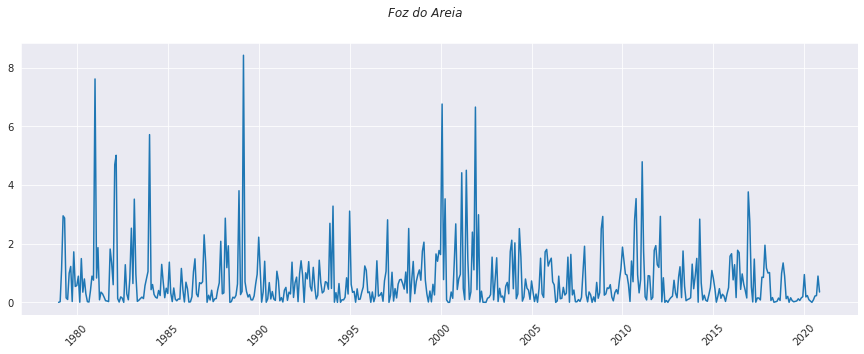

In [83]:
figura('/mnt/d/_Gabriel/Estudo/UFF/Bloqueios_Atmosfericos/shapes/shapes_smap/MODCLIM/Foz do Areia.shp')

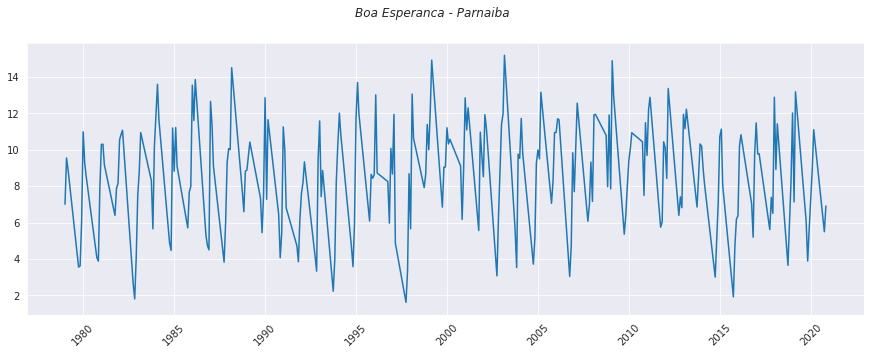

In [10]:
figura('/mnt/d/_Gabriel/Estudo/UFF/Bloqueios_Atmosfericos/data/shapes/shapes_smap/MODCLIM/Boa Esperanca - Parnaiba.shp')

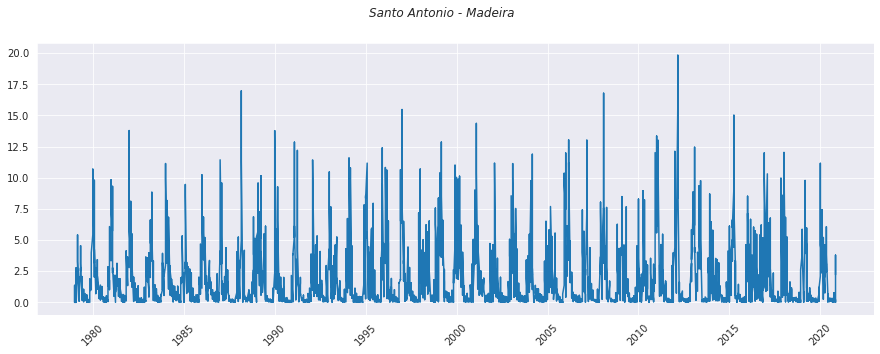

In [85]:
figura('/mnt/d/_Gabriel/Estudo/UFF/Bloqueios_Atmosfericos/shapes/shapes_smap/MODCLIM/Santo Antonio - Madeira.shp')

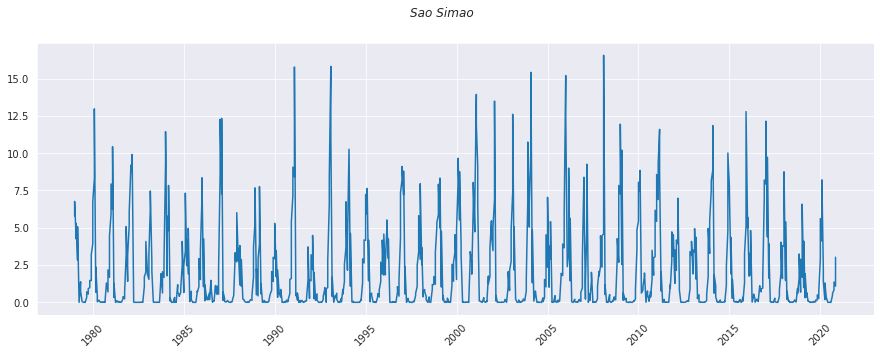

In [86]:
figura('/mnt/d/_Gabriel/Estudo/UFF/Bloqueios_Atmosfericos/shapes/shapes_smap/MODCLIM/Sao Simao.shp')

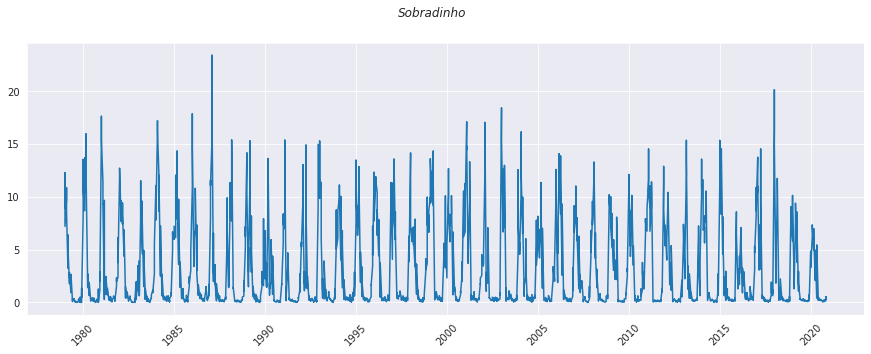

In [87]:
figura('/mnt/d/_Gabriel/Estudo/UFF/Bloqueios_Atmosfericos/shapes/shapes_smap/MODCLIM/Sobradinho.shp')

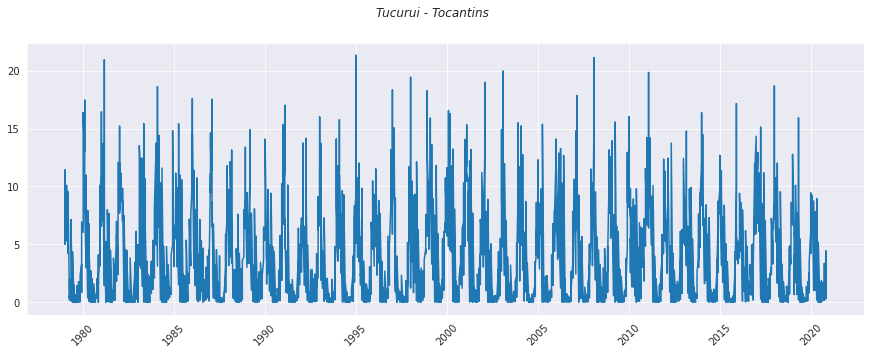

In [89]:
figura('/mnt/d/_Gabriel/Estudo/UFF/Bloqueios_Atmosfericos/shapes/shapes_smap/MODCLIM/Tucurui - Tocantins.shp')